In [1]:


from itertools import combinations
import pandas as pd
import numpy as np
from glob import glob
import os
from typing import Optional
import matplotlib.pyplot as plt

In [2]:
df = pd.read_hdf(r"C:\Users\agust\OneDrive\Desktop notebook casa\resultados paper\trial1_abeja(25).h5")  # load a single .h5 file by full path


In [3]:
df  # DataFrame with the data from the loaded file


scorer    DLC_resnet50_AbejasJun19shuffle1_150000                         \
bodyparts                                   manl1                          
coords                                          x           y likelihood   
0                                      286.411255  156.471985   0.999241   
1                                      286.366241  156.605774   0.999193   
2                                      287.728943  157.488602   0.999010   
3                                      288.383118  159.239685   0.998437   
4                                      290.137268  160.287659   0.996754   
...                                           ...         ...        ...   
1482                                   279.146637  150.358124   0.999274   
1483                                   282.408234  149.321304   0.999305   
1484                                   278.349640  150.212967   0.999515   
1485                                   278.336884  150.117569   0.999459   
1486                                   280.176422  150.009155   0.999404   

scorer                                                                \
bodyparts       manl2                              prob1               
coords              x           y likelihood           x           y   
0          277.099457  179.672821   0.997345  284.400818  177.984863   
1          276.960419  179.604630   0.997032  284.149628  178.279587   
2          277.820801  180.693069   0.996905  285.461395  179.237823   
3          277.511993  182.939331   0.995629  286.353485  181.841507   
4          277.386963  184.162201   0.995576  286.936951  183.304932   
...               ...         ...        ...         ...         ...   
1482       281.563110  171.338791   0.999368  289.396484  165.054993   
1483       283.079102  169.127243   0.999236  290.600555  163.054703   
1484       281.942352  169.982544   0.999499  290.061737  162.643753   
1485       281.645782  169.749146   0.999392  289.890015  162.952759   
1486       282.255920  169.502472   0.999451  290.160370  163.536392   

scorer                            ...                                     \
bodyparts                  prob2  ...      prob4       prob5               
coords    likelihood           x  ... likelihood           x           y   
0           0.998475  286.520966  ...   0.997459  297.620758  174.864456   
1           0.998525  286.405731  ...   0.998037  297.587585  175.066071   
2           0.997978  286.991669  ...   0.996186  297.680847  175.538773   
3           0.997342  287.065155  ...   0.996639  297.225372  178.925125   
4           0.996854  287.789795  ...   0.997472  298.303040  180.470291   
...              ...         ...  ...        ...         ...         ...   
1482        0.999784  286.896759  ...   0.999180  305.131866  162.064041   
1483        0.999524  286.746185  ...   0.999357  304.318970  159.903641   
1484        0.999671  286.784790  ...   0.999228  305.238647  158.996506   
1485        0.999708  287.026245  ...   0.999337  304.282410  160.141098   
1486        0.999806  287.322662  ...   0.998906  305.645782  160.153732   

scorer                                                               \
bodyparts                  manr1                              manr2   
coords    likelihood           x           y likelihood           x   
0           0.998782  304.824554  172.913513   0.997014  291.575684   
1           0.998945  304.547363  172.960800   0.997551  291.878204   
2           0.998114  305.327881  172.759781   0.996226  291.979431   
3           0.997569  305.856903  174.913864   0.995418  292.262238   
4           0.998830  307.013153  176.293625   0.994620  293.232788   
...              ...         ...         ...        ...         ...   
1482        0.998591  317.063507  165.030640   0.998709  311.134674   
1483        0.998585  315.142883  162.560226   0.998325  306.430878   
1484        0.998560  316.765381  164.227173   0.998679  309.508698   
1485     

In [4]:
# Access the values of the first level of the index
index_values = df.index.get_level_values(0)

# Add a new column to the DataFrame with those values; this creates a 'frames' column
# (you could also use the index directly)
df['frames'] = index_values
frames = df['frames']


In [5]:
# How to access the different levels of a MultiIndex in the columns
scorer = df.columns.levels[0][0]
individuals = list(df.columns.levels[1])
bodyparts = list(df.columns.levels[2])


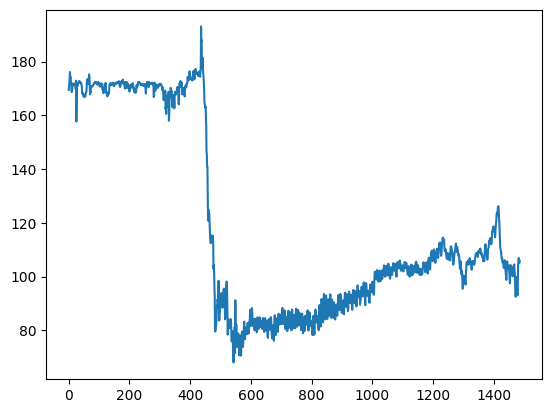

In [6]:
plt.plot(frames, df[scorer]["prob3"]["y"])  # frames on the x-axis; the rest are column MultiIndex levels:
# level 0 (scorer)  -> model/source name
# level 1 (bodypart)-> 'prob3'
# level 2 (coords)  -> 'y'
# General pattern: df[scorer][bodypart]['x' or 'y'] to plot X or Y coordinates


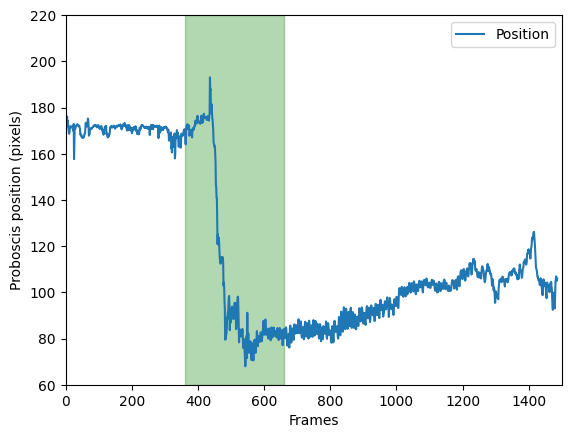

In [7]:

# Plot proboscis Y-position over frames (time) and mark the stimulus window
plt.plot(frames, df[scorer]["prob3"]["y"], label="Position")
plt.xlabel("Frames")
plt.ylabel("Proboscis position (pixels)")
plt.ylim(60, 220)      # Y-axis limits
plt.xlim(0, 1500)      # X-axis limits
plt.legend()

# Stimulus window (shaded)
plt.axvspan(xmin=360, xmax=660, color="green", alpha=0.3)

plt.show()


Multiple files into one: integrate all .h5 files into a single DataFrame by parsing the file name to get the trial and the animal ID. The script walks a folder, reads each .h5, checks for empty DataFrames, and appends data while keeping a dense index. Use the file name pattern (e.g., `Trial1_bee(3).h5`, `TestA_bee(10).h5`) to map entries to trials.

In [9]:
# This code assumes the file names follow the pattern `trialX_bee(X)` or `testX_bee(X)`
# Folder containing the .h5 files
carpeta = r"C:\Users\agust\OneDrive\Desktop notebook casa\resultados paper"

# List to store the processed DataFrames
dataframes = []
animal_numbers = []
trials = []

# Check that the folder exists and contains files
if not os.path.exists(carpeta):
    raise FileNotFoundError(f"The specified folder does not exist: {carpeta}")
if not os.listdir(carpeta):
    raise FileNotFoundError(f"The specified folder is empty: {carpeta}")

# Print the list of files in the folder
print(f"Files in folder '{carpeta}': {os.listdir(carpeta)}")

# Iterate over the files in the folder
for archivo in os.listdir(carpeta):
    if archivo.endswith('.h5'):
        print(f"Processing file: {archivo}")
        # Read the .h5 file
        ruta_archivo = os.path.join(carpeta, archivo)
        try:
            df = pd.read_hdf(ruta_archivo)
            print(f"File read successfully: {archivo}")
        except Exception as e:
            print(f"Error reading file {archivo}: {e}")
            continue
        
        # Check if the DataFrame is empty
        if df.empty:
            print(f"The file {archivo} is empty.")
            continue
        
        # Access the values of the first level of the index
        valores_indice = df.index.get_level_values(0)
        
        # Add a new column to the DataFrame with those values
        df['frames'] = valores_indice
        
        # Extract the trial and animal number from the file name
        try:
            partes_nombre = archivo.split('_')
            trial = partes_nombre[0]
            animal_name = partes_nombre[1].split('.')[0]  # Remove .h5 extension
            animal_number = animal_name.split('(')[1].split(')')[0]
            
            # Add the animal number and the trial to the corresponding lists
            animal_numbers.extend([int(animal_number)] * len(df))
            trials.extend([trial] * len(df))
        except (IndexError, ValueError):
            print(f"Error processing file: {archivo}")
            continue
        
        # Add the modified DataFrame to the list
        dataframes.append(df)
        print(f"File processed successfully: {archivo}")

# Check if there are DataFrames in the list
if not dataframes:
    raise ValueError("No DataFrames were found to concatenate.")

# Concatenate all DataFrames into a single one
df_final = pd.concat(dataframes)

# Add the new columns to the final DataFrame
df_final['animal'] = animal_numbers
df_final['trial'] = trials

print("Concatenation completed successfully. Final DataFrame:")
print(df_final.head())


Files in folder 'C:\Users\agust\OneDrive\Desktop notebook casa\resultados paper': ['abejas DLC paper.ipynb', 'codigo paper.ipynb', 'Codigo_DLC_abejas.ipynb', 'codigo_DLC_paper.ipynb', 'radar.ipynb', 'testA_abeja(1).h5', 'testA_abeja(10).h5', 'testA_abeja(11).h5', 'testA_abeja(12).h5', 'testA_abeja(13).h5', 'testA_abeja(14).h5', 'testA_abeja(15).h5', 'testA_abeja(16).h5', 'testA_abeja(17).h5', 'testA_abeja(18).h5', 'testA_abeja(19).h5', 'testA_abeja(2).h5', 'testA_abeja(20).h5', 'testA_abeja(21).h5', 'testA_abeja(22).h5', 'testA_abeja(23).h5', 'testA_abeja(24).h5', 'testA_abeja(25).h5', 'testA_abeja(3).h5', 'testA_abeja(4).h5', 'testA_abeja(5).h5', 'testA_abeja(6).h5', 'testA_abeja(7).h5', 'testA_abeja(8).h5', 'testA_abeja(9).h5', 'testH_abeja(1).h5', 'testH_abeja(10).h5', 'testH_abeja(11).h5', 'testH_abeja(12).h5', 'testH_abeja(13).h5', 'testH_abeja(14).h5', 'testH_abeja(15).h5', 'testH_abeja(16).h5', 'testH_abeja(17).h5', 'testH_abeja(18).h5', 'testH_abeja(19).h5', 'testH_abeja(2).h5'

In [10]:
df_final

scorer    DLC_resnet50_AbejasJun19shuffle1_150000                         \
bodyparts                                   manl1                          
coords                                          x           y likelihood   
0                                      344.043182  169.840775   0.999668   
1                                      343.636871  170.052750   0.999640   
2                                      344.292572  169.345947   0.999681   
3                                      343.332092  169.934250   0.999773   
4                                      344.012115  169.806320   0.999636   
...                                           ...         ...        ...   
1482                                   333.006653  173.678467   0.999193   
1483                                   331.725647  173.302856   0.999114   
1484                                   339.341827  174.229477   0.996611   
1485                                   332.947998  173.299438   0.999796   
1486                                   332.435089  173.241241   0.999623   

scorer                                                                \
bodyparts       manl2                              prob1               
coords              x           y likelihood           x           y   
0          318.538818  190.270523   0.999804  330.978149  188.655243   
1          318.426727  190.409058   0.999796  330.704376  188.710938   
2          318.375305  190.708862   0.999683  330.571503  188.731812   
3          317.956879  190.615967   0.999718  330.070160  188.590317   
4          318.005066  191.666107   0.999784  330.800507  188.932861   
...               ...         ...        ...         ...         ...   
1482       322.414459  195.219727   0.997232  331.734070  193.516098   
1483       322.892090  194.721558   0.997205  332.119141  192.286896   
1484       322.016693  195.526901   0.996872  332.447937  195.432434   
1485       320.723541  195.848358   0.997718  330.642334  195.038635   
1486       320.725922  196.528366   0.998230  330.706207  195.217285   

scorer                            ...                                     \
bodyparts                  prob2  ...      prob5       manr1               
coords    likelihood           x  ... likelihood           x           y   
0           0.998707  335.900909  ...   0.999315  354.707153  193.324554   
1           0.998765  335.846710  ...   0.999176  354.840942  193.471970   
2           0.998704  336.172577  ...   0.999238  354.862213  194.083145   
3           0.998701  335.652618  ...   0.999114  354.011230  193.677246   
4           0.998438  336.100739  ...   0.999350  354.882233  193.307312   
...              ...         ...  ...        ...         ...         ...   
1482        0.998656  334.354645  ...   0.999079  353.258057  195.668045   
1483        0.998280  334.349945  ...   0.999041  353.234039  195.322266   
1484        0.997928  335.118988  ...   0.999130  354.904114  197.101028   
1485        0.998362  334.081360  ...   0.998428  352.585052  195.619080   
1486        0.998436  333.887207  ...   0.998591  352.986725  197.106857   

scorer                                                  frames animal   trial  
bodyparts                  manr2                                               
coords    likelihood           x           y likelihood                        
0           0.995712  347.585052  170.571609   0.997776      0      1   testA  
1           0.995320  347.040100  170.451401   0.997693      1      1   testA  
2           0.995304  348.053589  170.395874   0.997621      2      1   testA  
3           0.995281  347.027588  170.854721   0.997319      3      1   testA  
4           0.995452  347.928802  170.313934   0.997923      4      1   testA  
...              ...         ...         ...        ...    ...    ...     ...  
1482        0.996665  348.758514  172.965775   0.998348   1482      9  trial1  
1483        0.997379  348.138397  172.806229   0.998752   148

In [12]:
# Verify the structure of the columns (MultiIndex)
print(df_final.columns)

# Filter values in the 'likelihood' subcolumn of 'prob3' that are less than 0.90
values_below_090 = df_final[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob3', 'likelihood')] < 0.90

# Count how many values are < 0.90
count_below_090 = values_below_090.sum()

print(f"The number of values in the 'likelihood' subcolumn of 'prob3' below 0.90 is: {count_below_090}")


MultiIndex([('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl1',          'x'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl1',          'y'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl1', 'likelihood'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl2',          'x'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl2',          'y'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl2', 'likelihood'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1',          'x'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1',          'y'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1', 'likelihood'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob2',          'x'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob2',          'y'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob2', 'likelihood'),
            ('DLC_resnet50_AbejasJun19sh

In [13]:
# Assume df_final is your original DataFrame (already loaded)

# Inspect the column structure (MultiIndex)
print(df_final.columns)

# Build a mask: keep rows where 'prob3' -> 'likelihood' is >= 0.90
mask = df_final[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob3', 'likelihood')] >= 0.90

# Create the filtered DataFrame
df_filtered = df_final[mask]

# Verify the result
print(df_filtered.columns)
print(f"The number of rows in the new DataFrame is: {df_filtered.shape[0]}")


MultiIndex([('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl1',          'x'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl1',          'y'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl1', 'likelihood'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl2',          'x'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl2',          'y'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'manl2', 'likelihood'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1',          'x'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1',          'y'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1', 'likelihood'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob2',          'x'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob2',          'y'),
            ('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob2', 'likelihood'),
            ('DLC_resnet50_AbejasJun19sh

In [ ]:
# Assuming you have df_final with the given structure and want to smooth the data with a moving-average window
window = 10  # moving-average window (in frames)

# Plot prob3 'y' vs. frames per animal and per trial with smoothing
for (animal, trial), group in df_filtered.groupby(['animal', 'trial']):
    plt.figure(figsize=(10, 6))
    smoothed_data = group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob3', 'y')]\
        .rolling(window=window, min_periods=1).mean()
    plt.plot(group['frames'], smoothed_data, label=f"Smoothed (window {window})")
    plt.title(f"Animal {animal} — Trial {trial}")
    plt.xlabel("Frames")
    plt.ylabel("Proboscis Y (pixels)")
    plt.legend()
    plt.show()

    

In [ ]:
# Assuming you have df_filtered with the expected structure and you want a 15-point moving average
window = 15  # moving-average window (in frames)

# Plot (prob3_y - prob1_y) vs. frames per animal and trial, with smoothing and normalization
for (animal, trial), group in df_filtered.groupby(['animal', 'trial']):
    plt.figure(figsize=(10, 6))

    # Compute the difference between prob3 and prob1 in the Y position
    difference = (
        group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob3', 'y')]
        - group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1', 'y')]
    )

    # Apply smoothing to the difference
    smoothed_difference = difference.rolling(window=window, min_periods=1).mean()

    # Get the 100 smallest values of the smoothed difference
    smallest_100 = smoothed_difference.nsmallest(100)

    # Compute the mode of those 100 smallest values (first if multiple)
    top_100_mode = smallest_100.mode().iloc[0] if not smallest_100.empty else 0.0

    # Normalize by subtracting the mode of the 100 smallest values
    normalized_data = smoothed_difference - top_100_mode

    plt.plot(group['frames'], normalized_data, label=f"Smoothed & normalized (window {window})")
    plt.title(f"Animal {animal} — Trial {trial}")
    plt.xlabel("Frames")
    plt.ylabel("Difference in Y (prob3 - prob1)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
pip install seaborn

behavioral features and behavioral analysis

In [ ]:
# Assuming you have df_filtered with the expected structure and you want to smooth with a 10-point moving-average window
window = 10  # moving-average window (in frames)

# Create a new binary response based on a threshold of -15 after smoothing and normalization
for (animal, trial), group in df_filtered.groupby(['animal', 'trial']):
    plt.figure(figsize=(10, 6))

    # Compute the difference between prob3 and prob1 in the Y position
    difference = (
        group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob3', 'y')]
        - group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1', 'y')]
    )

    # Apply smoothing to the difference
    smoothed_difference = difference.rolling(window=window, min_periods=1).mean()

    # Get the top 100 values of the smoothed difference
    top_100_values = smoothed_difference.nlargest(100)

    # Compute the mode of the top 100 values (use the first if multiple modes)
    top_100_mode = top_100_values.mode().iloc[0] if not top_100_values.empty else 0.0

    # Normalize by subtracting the mode of the top 100 values
    normalized_data = smoothed_difference - top_100_mode

    # Clip data to frame <= 1790 (purely for visualization)
    mask_frames = group['frames'] <= 1790
    normalized_data = normalized_data.loc[mask_frames]
    group = group.loc[mask_frames]

    # Convert to a binary response based on the threshold of -15
    binary_response = (normalized_data < -15).astype(int)

    # Plot the binary response and shade under the curve
    plt.plot(group['frames'], binary_response, label='Binary response', linewidth=1.5)
    plt.fill_between(group['frames'], binary_response, alpha=0.3, label='Area under curve')

    plt.title(f"Animal {animal} — Trial {trial}")
    plt.xlabel("Frames")
    plt.ylabel("Binary response")
    plt.legend()
    plt.tight_layout()
    plt.show()


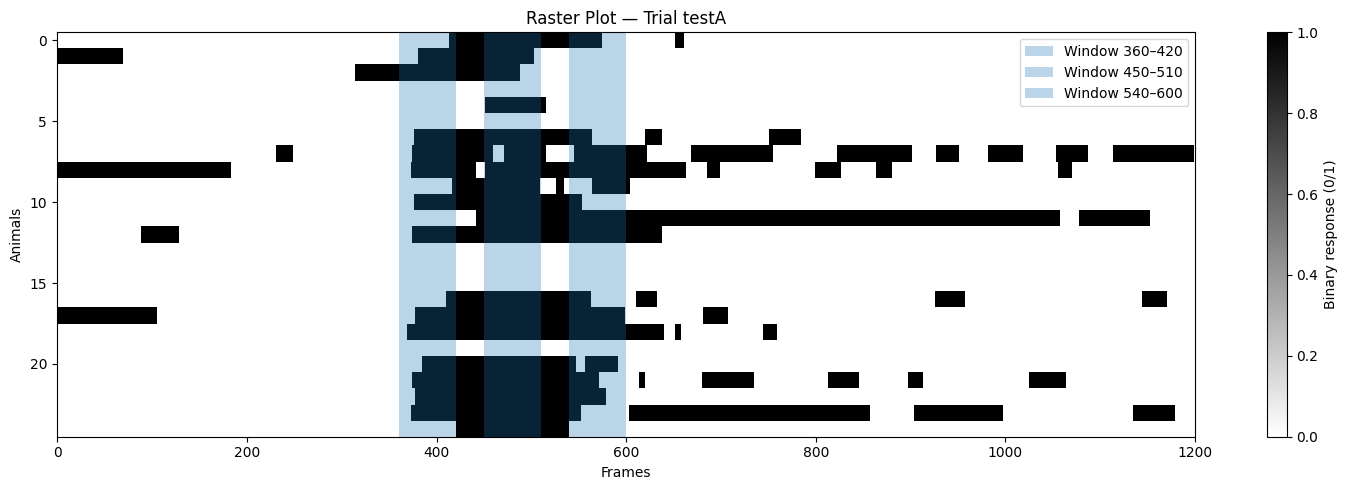

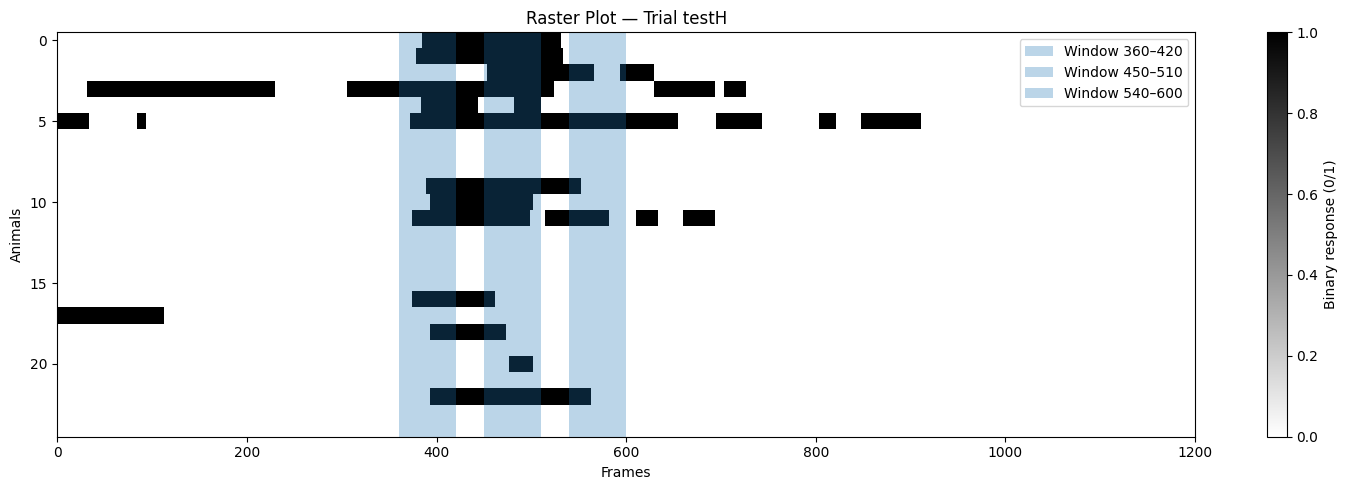

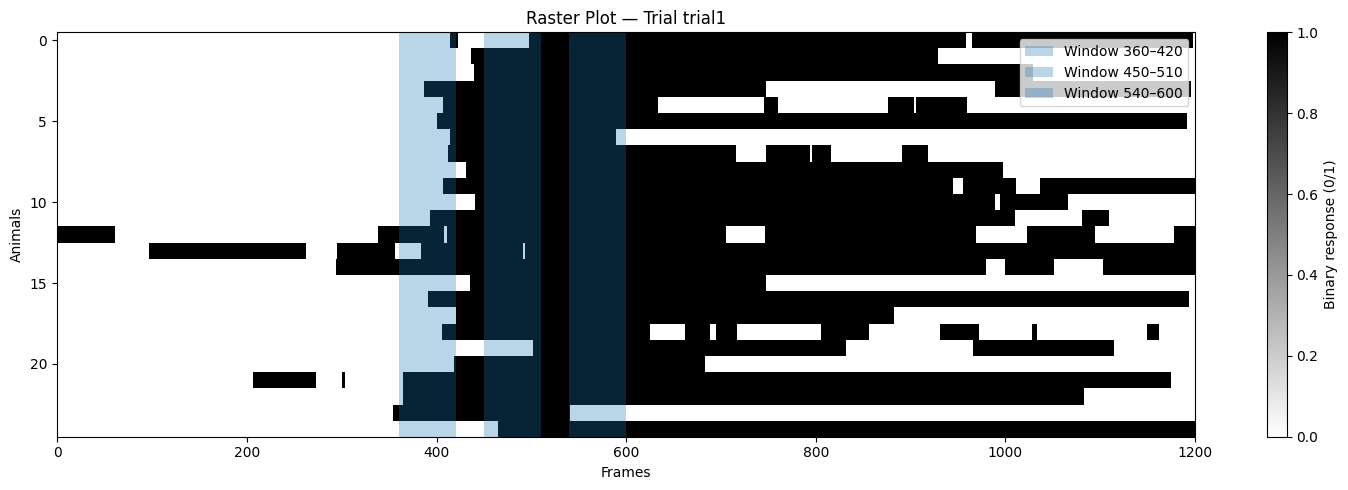

In [19]:
# Assuming you have df_filtered with the expected structure and want a 15-point moving average
window = 15

# Initialize a dictionary to store the binary responses for each trial
trial_responses = {}

# Build a new binary response based on a threshold of -25
for (animal, trial), group in df_filtered.groupby(['animal', 'trial']):
    # Compute the difference between prob3 and prob1 in the Y position
    difference = (
        group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob3', 'y')]
        - group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1', 'y')]
    )

    # Apply smoothing to the difference
    smoothed_difference = difference.rolling(window=window, min_periods=1).mean()

    # Get the top 100 values of the smoothed difference
    top_100_values = smoothed_difference.nlargest(100)

    # Compute the median of the top 100 values (0.0 if empty)
    top_100_median = top_100_values.median() if not top_100_values.empty else 0.0

    # Normalize by subtracting the median of the top 100 values
    normalized_data = smoothed_difference - top_100_median

    # (Optional) clip data to frame <= 1200 for visualization consistency
    # If you prefer truly unconstrained length, comment these two lines out.
    mask_1200 = group['frames'] <= 1200
    normalized_data = normalized_data.loc[mask_1200]
    group = group.loc[mask_1200]

    # Binary response (1 if below −25)
    binary_response = (normalized_data < -25).astype(int)

    # Store responses in the dictionary
    trial_responses.setdefault(trial, {})[animal] = binary_response.values

# ---- Dynamic-width raster per trial ----
for trial, responses in trial_responses.items():
    if not responses:
        continue

    # Determine dynamic width based on the longest response
    max_len = max(len(resp) for resp in responses.values())
    if max_len == 0:
        continue

    raster_plot = np.zeros((len(responses), max_len), dtype=int)

    # Fill the array with each animal's binary responses (trim if any longer than max_len)
    for idx, (animal, response) in enumerate(responses.items()):
        L = min(len(response), max_len)
        raster_plot[idx, :L] = response[:L]

    # Plot the raster plot for this trial
    fig, ax = plt.subplots(figsize=(15, 5))
    im = ax.imshow(raster_plot, cmap='binary', aspect='auto', interpolation='none')

    # Helper to add shaded spans safely within [0, max_len)
    def add_safe_span(ax, a, b, **kw):
        a = int(max(0, min(a, max_len - 1)))
        b = int(max(0, min(b, max_len - 1)))
        if b > a:
            ax.axvspan(a, b, **kw)

    # Add translucent bars for stimulus windows (clamped to available width)
    add_safe_span(ax, 360, 420, alpha=0.3, label='Window 360–420')
    add_safe_span(ax, 450, 510, alpha=0.3, label='Window 450–510')
    add_safe_span(ax, 540, 600, alpha=0.3, label='Window 540–600')

    ax.set_xlabel('Frames')
    ax.set_ylabel('Animals')
    ax.set_title(f'Raster Plot — Trial {trial}')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Binary response (0/1)')

    # Show legend only if at least one span was drawn
    # (Quick check: if any label exists in legend handles)
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()



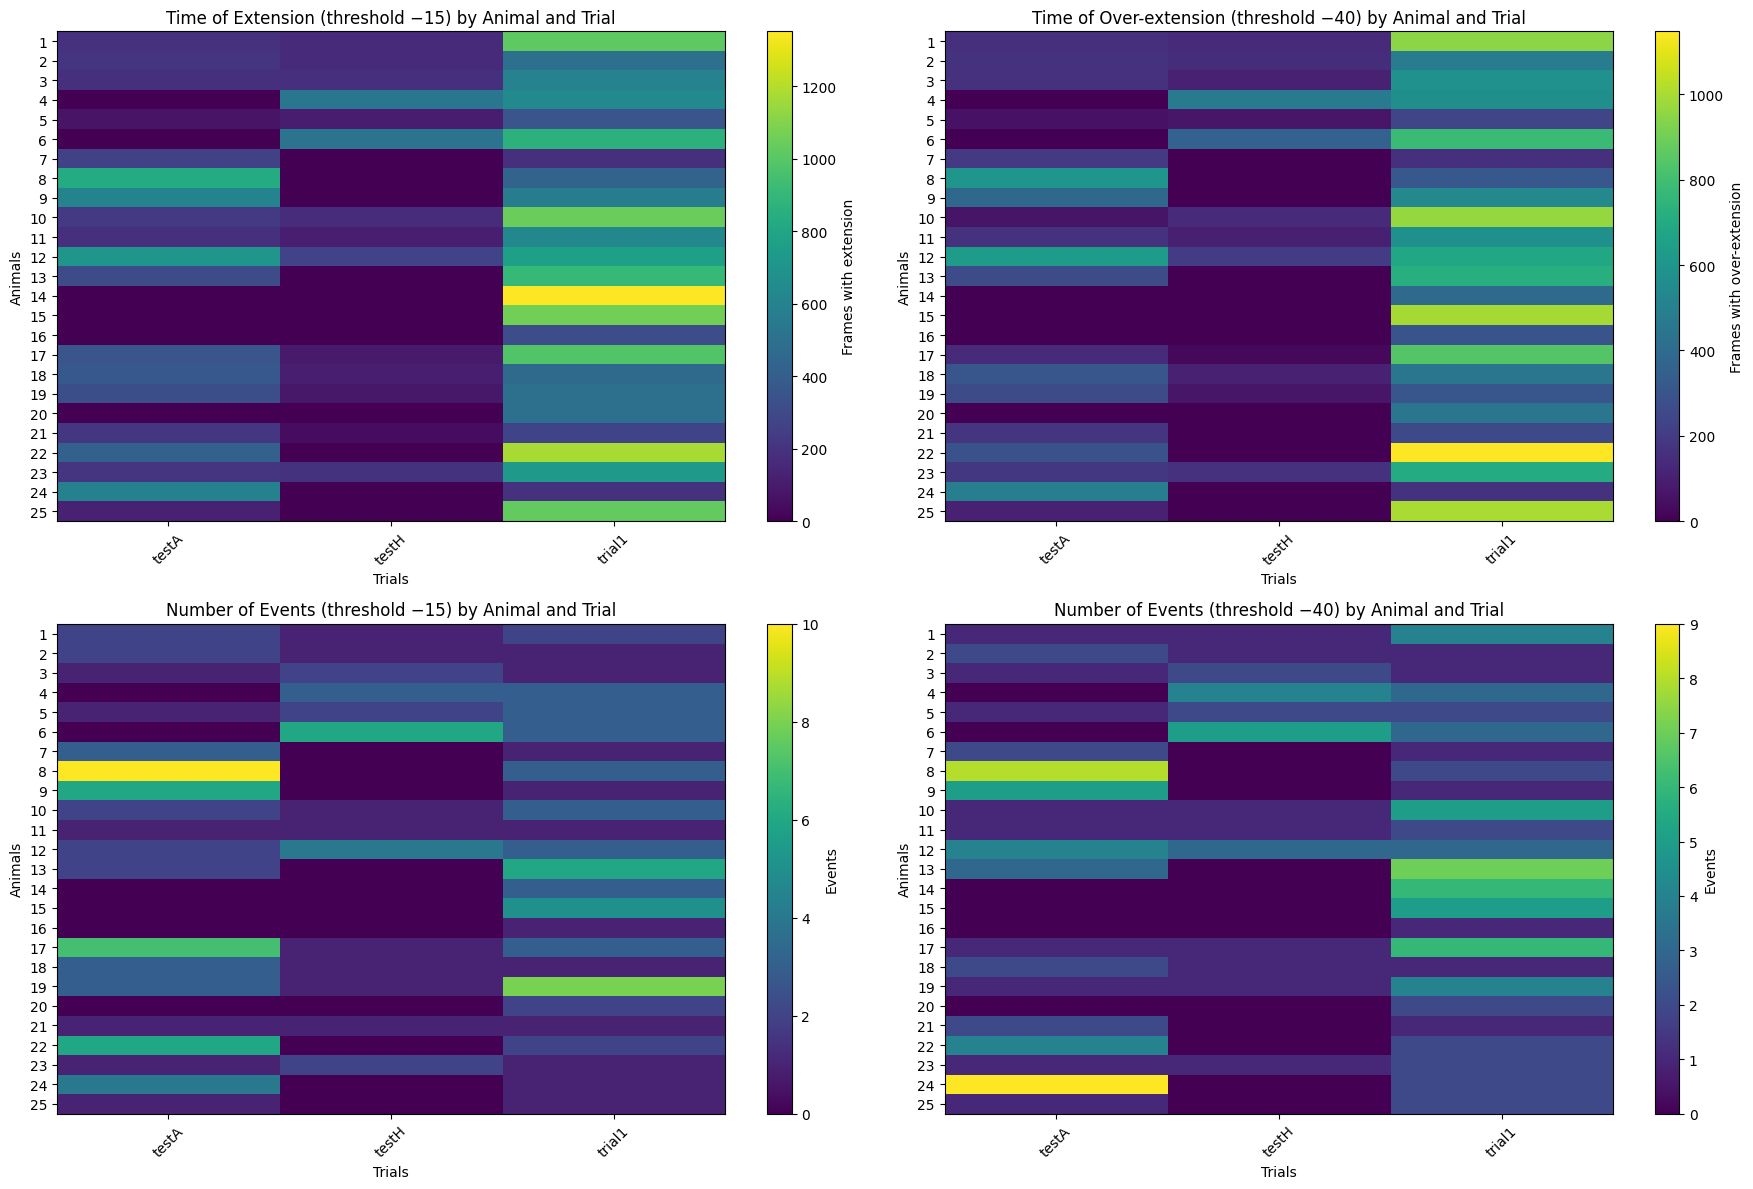

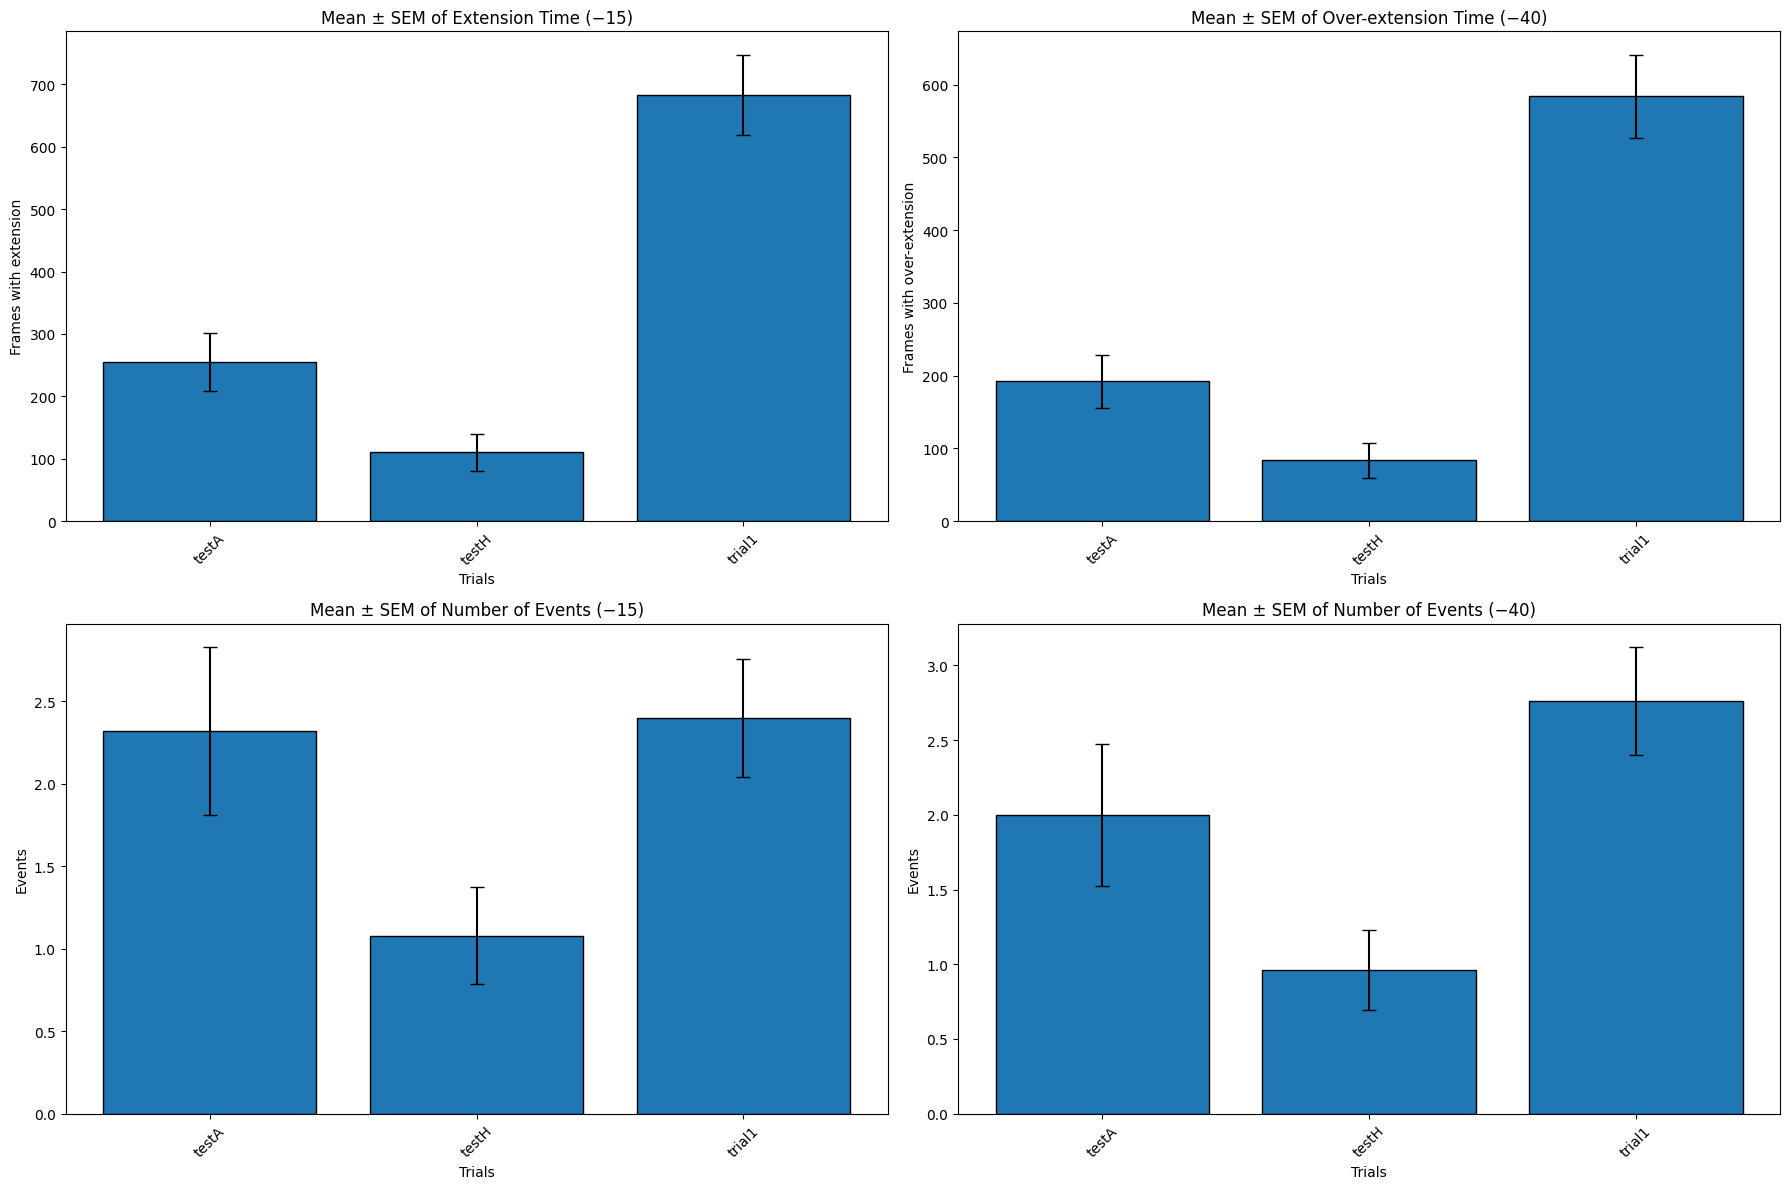

In [21]:
# --- Parameters ---
window = 15           # smoothing window (frames)
FRAME_MAX = 1790      # upper frame clip
UMBRAL_EXT = -15      # threshold for extensions
UMBRAL_OVER = -40     # threshold for over-extensions
MIN_RUN = 15          # filter out runs of 1s shorter than this (in frames)

# Result dictionaries
trial_extension_times = {}       # time (frames with 1) for EXT
trial_event_counts = {}          # number of events (contiguous 1s) for EXT
trial_over_extension_times = {}  # time (frames with 1) for OVER
trial_over_event_counts = {}     # number of events (contiguous 1s) for OVER

# ---- Helper functions ----
def count_events(binary_response):
    """Count events (contiguous blocks of 1s) in a binary vector."""
    events = 0
    in_event = False
    for v in binary_response:
        if v == 1:
            if not in_event:
                events += 1
                in_event = True
        else:
            in_event = False
    return events

def filter_short_sequences(binary_response, threshold=15):
    """Keep only sequences of 1s with length > threshold."""
    x = np.asarray(binary_response).astype(int)
    y = np.zeros_like(x)
    count = 0
    for i, v in enumerate(x):
        if v == 1:
            count += 1
        else:
            if count > threshold:
                y[i-count:i] = 1
            count = 0
    if count > threshold:
        y[len(x)-count:] = 1
    return y

def binarize_and_measure(norm_series, umbral, min_run=MIN_RUN):
    """Binarize by threshold, filter short runs, and return (time, events)."""
    binary = (norm_series < umbral).astype(int).values
    filtered = filter_short_sequences(binary, threshold=min_run)
    extension_time = int(filtered.sum())
    num_events = int(count_events(filtered))
    return extension_time, num_events

# ---- Computation by (animal, trial) ----
for (animal, trial), group in df_filtered.groupby(['animal', 'trial']):
    # difference prob3 - prob1 in Y
    diff = (group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob3', 'y')]
            - group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1', 'y')])

    # smoothing (avoid NaNs at the beginning)
    smoothed = diff.rolling(window=window, min_periods=1).mean()

    # normalization by median of the top-100 values of the smoothed signal
    top_100 = smoothed.nlargest(100)
    top_100_median = top_100.median() if len(top_100) > 0 else 0.0
    norm = smoothed - top_100_median

    # clip by frame
    m = group['frames'] <= FRAME_MAX
    norm = norm.loc[m]
    group_sub = group.loc[m]

    # ---- Metrics for EXT (−15) ----
    ext_time, ext_events = binarize_and_measure(norm, UMBRAL_EXT, MIN_RUN)
    trial_extension_times.setdefault(trial, {})[animal] = ext_time
    trial_event_counts.setdefault(trial, {})[animal]   = ext_events

    # ---- Metrics for OVER (−40) ----
    over_time, over_events = binarize_and_measure(norm, UMBRAL_OVER, MIN_RUN)
    trial_over_extension_times.setdefault(trial, {})[animal] = over_time
    trial_over_event_counts.setdefault(trial, {})[animal]   = over_events

# ---- DataFrames (animals x trials) ----
extension_times_df      = pd.DataFrame(trial_extension_times).fillna(0).astype(int)
event_counts_df         = pd.DataFrame(trial_event_counts).fillna(0).astype(int)
over_extension_times_df = pd.DataFrame(trial_over_extension_times).fillna(0).astype(int)
over_event_counts_df    = pd.DataFrame(trial_over_event_counts).fillna(0).astype(int)

# Ensure column (trial) order
cols_sorted = sorted(extension_times_df.columns)
extension_times_df      = extension_times_df.reindex(cols_sorted, axis=1)
event_counts_df         = event_counts_df.reindex(cols_sorted, axis=1)
over_extension_times_df = over_extension_times_df.reindex(cols_sorted, axis=1)
over_event_counts_df    = over_event_counts_df.reindex(cols_sorted, axis=1)

# ---- Statistics per trial (columns) ----
# Means
extension_times_mean      = extension_times_df.mean(axis=0)
event_counts_mean         = event_counts_df.mean(axis=0)
over_extension_times_mean = over_extension_times_df.mean(axis=0)
over_event_counts_mean    = over_event_counts_df.mean(axis=0)

# SEM (standard error of the mean)
extension_times_sem      = extension_times_df.sem(axis=0, ddof=1)
event_counts_sem         = event_counts_df.sem(axis=0, ddof=1)
over_extension_times_sem = over_extension_times_df.sem(axis=0, ddof=1)
over_event_counts_sem    = over_event_counts_df.sem(axis=0, ddof=1)

# ---- FIGURE 1: Heatmaps (4) ----
fig1, axes1 = plt.subplots(2, 2, figsize=(18, 12))

# Heatmap: EXT time
im1 = axes1[0, 0].imshow(extension_times_df.values, cmap='viridis', aspect='auto')
axes1[0, 0].set_title('Time of Extension (threshold −15) by Animal and Trial')
axes1[0, 0].set_xlabel('Trials'); axes1[0, 0].set_ylabel('Animals')
axes1[0, 0].set_xticks(np.arange(extension_times_df.shape[1]))
axes1[0, 0].set_xticklabels(extension_times_df.columns, rotation=45)
axes1[0, 0].set_yticks(np.arange(extension_times_df.shape[0]))
axes1[0, 0].set_yticklabels(extension_times_df.index)
fig1.colorbar(im1, ax=axes1[0, 0], label='Frames with extension')

# Heatmap: OVER time
im2 = axes1[0, 1].imshow(over_extension_times_df.values, cmap='viridis', aspect='auto')
axes1[0, 1].set_title('Time of Over-extension (threshold −40) by Animal and Trial')
axes1[0, 1].set_xlabel('Trials'); axes1[0, 1].set_ylabel('Animals')
axes1[0, 1].set_xticks(np.arange(over_extension_times_df.shape[1]))
axes1[0, 1].set_xticklabels(over_extension_times_df.columns, rotation=45)
axes1[0, 1].set_yticks(np.arange(over_extension_times_df.shape[0]))
axes1[0, 1].set_yticklabels(over_extension_times_df.index)
fig1.colorbar(im2, ax=axes1[0, 1], label='Frames with over-extension')

# Heatmap: EXT events
im3 = axes1[1, 0].imshow(event_counts_df.values, cmap='viridis', aspect='auto')
axes1[1, 0].set_title('Number of Events (threshold −15) by Animal and Trial')
axes1[1, 0].set_xlabel('Trials'); axes1[1, 0].set_ylabel('Animals')
axes1[1, 0].set_xticks(np.arange(event_counts_df.shape[1]))
axes1[1, 0].set_xticklabels(event_counts_df.columns, rotation=45)
axes1[1, 0].set_yticks(np.arange(event_counts_df.shape[0]))
axes1[1, 0].set_yticklabels(event_counts_df.index)
fig1.colorbar(im3, ax=axes1[1, 0], label='Events')

# Heatmap: OVER events
im4 = axes1[1, 1].imshow(over_event_counts_df.values, cmap='viridis', aspect='auto')
axes1[1, 1].set_title('Number of Events (threshold −40) by Animal and Trial')
axes1[1, 1].set_xlabel('Trials'); axes1[1, 1].set_ylabel('Animals')
axes1[1, 1].set_xticks(np.arange(over_event_counts_df.shape[1]))
axes1[1, 1].set_xticklabels(over_event_counts_df.columns, rotation=45)
axes1[1, 1].set_yticks(np.arange(over_event_counts_df.shape[0]))
axes1[1, 1].set_yticklabels(over_event_counts_df.index)
fig1.colorbar(im4, ax=axes1[1, 1], label='Events')

fig1.tight_layout()

# ---- FIGURE 2: Bar charts (4) ----
fig2, axes2 = plt.subplots(2, 2, figsize=(18, 12))

# Bars: EXT time
axes2[0, 0].bar(extension_times_mean.index, extension_times_mean.values,
                yerr=extension_times_sem.values, capsize=5,
                edgecolor='black')
axes2[0, 0].set_title('Mean ± SEM of Extension Time (−15)')
axes2[0, 0].set_xlabel('Trials'); axes2[0, 0].set_ylabel('Frames with extension')
axes2[0, 0].tick_params(axis='x', rotation=45)

# Bars: OVER time
axes2[0, 1].bar(over_extension_times_mean.index, over_extension_times_mean.values,
                yerr=over_extension_times_sem.values, capsize=5,
                edgecolor='black')
axes2[0, 1].set_title('Mean ± SEM of Over-extension Time (−40)')
axes2[0, 1].set_xlabel('Trials'); axes2[0, 1].set_ylabel('Frames with over-extension')
axes2[0, 1].tick_params(axis='x', rotation=45)

# Bars: EXT events
axes2[1, 0].bar(event_counts_mean.index, event_counts_mean.values,
                yerr=event_counts_sem.values, capsize=5,
                edgecolor='black')
axes2[1, 0].set_title('Mean ± SEM of Number of Events (−15)')
axes2[1, 0].set_xlabel('Trials'); axes2[1, 0].set_ylabel('Events')
axes2[1, 0].tick_params(axis='x', rotation=45)

# Bars: OVER events
axes2[1, 1].bar(over_event_counts_mean.index, over_event_counts_mean.values,
                yerr=over_event_counts_sem.values, capsize=5,
                edgecolor='black')
axes2[1, 1].set_title('Mean ± SEM of Number of Events (−40)')
axes2[1, 1].set_xlabel('Trials'); axes2[1, 1].set_ylabel('Events')
axes2[1, 1].tick_params(axis='x', rotation=45)

fig2.tight_layout()
plt.show()


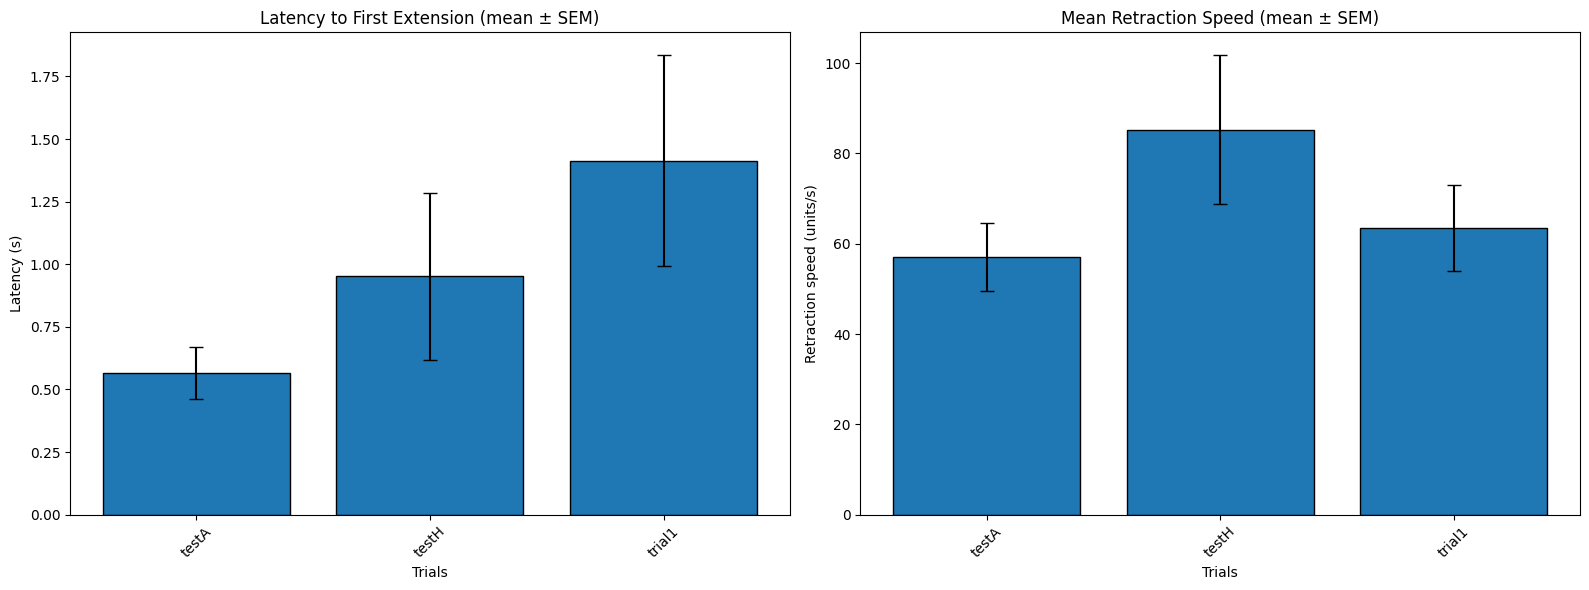

In [24]:
# ================== Parameters (adjust to your experiment) ==================
window = 15           # smoothing window (frames)
FRAME_MAX = 1790      # last frame to consider
UMBRAL_EXT = -30      # threshold to consider an extension (on your normalized signal)
MIN_RUN = 15          # minimum duration (in frames) to keep an event
stim_frame = 360      # frame where the stimulus starts (ADJUST)
fps = 60              # frames per second (ADJUST)
# =========================================================================

# Result dictionaries (per trial -> animal -> value)
latency_dict = {}           # latency (s)
retract_speed_dict = {}     # mean retraction speed (units/s)

# ------------------- Helper functions -------------------
def filter_short_sequences(binary_response, threshold=15):
    """Keep only sequences of 1s with length > threshold."""
    x = np.asarray(binary_response).astype(int)
    y = np.zeros_like(x)
    count = 0
    for i, v in enumerate(x):
        if v == 1:
            count += 1
        else:
            if count > threshold:
                y[i-count:i] = 1
            count = 0
    if count > threshold:
        y[len(x)-count:] = 1
    return y

def find_events_runs(filtered):
    """
    Return arrays 'starts' and 'ends' (end is exclusive) with the blocks of 1s.
    """
    f = np.asarray(filtered).astype(int)
    # Differences with padding to detect edges
    d = np.diff(np.r_[0, f, 0])
    starts = np.flatnonzero(d == 1)
    ends   = np.flatnonzero(d == -1)
    return starts, ends  # same length, pairs (start, end)

# ------------------- Loop by (animal, trial) -------------------
for (animal, trial), group in df_filtered.groupby(['animal', 'trial']):
    # Baseline signal: difference prob3 - prob1 in Y
    diff = (group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob3', 'y')]
            - group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1', 'y')])

    # Smoothing
    smoothed = diff.rolling(window=window, min_periods=1).mean()

    # Normalization: median of the top 100 values of the smoothed signal
    top_100 = smoothed.nlargest(100)
    top_100_median = top_100.median() if len(top_100) > 0 else 0.0
    norm = smoothed - top_100_median

    # Clipping by frame
    m = group['frames'] <= FRAME_MAX
    norm = norm.loc[m]
    # Ensure a dense index 0..N-1 for position-based indexing
    norm = norm.reset_index(drop=True)

    # Binarization by threshold
    binary = (norm < UMBRAL_EXT).astype(int).values

    # Filter out short runs
    filtered = filter_short_sequences(binary, threshold=MIN_RUN)

    # ---------------- Latency to the first extension ----------------
    # First event start with start >= stim_frame
    starts, ends = find_events_runs(filtered)
    # Ensure that `stim_frame` is within range
    sf = int(min(max(stim_frame, 0), len(filtered)))
    # Find the first event that starts at or after `stim_frame`
    starts_after = starts[starts >= sf]
    if starts_after.size > 0:
        first_start = int(starts_after[0])
        latency_frames = first_start - sf
        latency_sec = latency_frames / fps
    else:
        latency_sec = np.nan

    # ---------------- Mean retraction speed ----------------
    # For each event: from the minimum (most negative) to the end of the event.
    # Speed = |Δy| / Δt (positive), averaged across all events of the trial/animal.
    norm_vals = norm.values
    retraction_speeds = []
    for s, e in zip(starts, ends):
        # Event segment [s, e) (end exclusive)
        seg = norm_vals[s:e]
        if seg.size < 3:
            continue
        # Index of the minimum within the event (proboscis most extended: most negative value)
        k_min = int(np.argmin(seg))
        peak_idx = s + k_min
        end_idx = e - 1  # last frame inside the event
        dt_frames = end_idx - peak_idx
        if dt_frames <= 0:
            continue
        dy = norm_vals[end_idx] - norm_vals[peak_idx]  # should be positive (returns upward)
        dt_sec = dt_frames / fps
        speed = abs(dy) / dt_sec
        retraction_speeds.append(speed)

    mean_retract_speed = np.mean(retraction_speeds) if len(retraction_speeds) > 0 else np.nan

    # ---------------- Save results ----------------
    latency_dict.setdefault(trial, {})[animal] = latency_sec
    retract_speed_dict.setdefault(trial, {})[animal] = mean_retract_speed

# ------------------- DataFrames animals × trials -------------------
latency_df = pd.DataFrame(latency_dict)              # seconds
retract_speed_df = pd.DataFrame(retract_speed_dict)  # units/s (depends on your signal)

# Sort columns by trial if they are not already ordered
if latency_df.shape[1] > 0:
    latency_df = latency_df.reindex(sorted(latency_df.columns), axis=1)
if retract_speed_df.shape[1] > 0:
    retract_speed_df = retract_speed_df.reindex(sorted(retract_speed_df.columns), axis=1)

# ------------------- Statistics per trial -------------------
# Means (NaN ignored by default)
lat_mean = latency_df.mean(axis=0)
lat_sem  = latency_df.sem(axis=0, ddof=1)

ret_mean = retract_speed_df.mean(axis=0)
ret_sem  = retract_speed_df.sem(axis=0, ddof=1)

# ------------------- Bar plots: mean ± SEM -------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Latency
axes[0].bar(lat_mean.index, lat_mean.values,
            yerr=lat_sem.values, capsize=5, edgecolor='black')
axes[0].set_title('Latency to First Extension (mean ± SEM)')
axes[0].set_xlabel('Trials')
axes[0].set_ylabel('Latency (s)')
axes[0].tick_params(axis='x', rotation=45)

# Retraction speed
axes[1].bar(ret_mean.index, ret_mean.values,
            yerr=ret_sem.values, capsize=5, edgecolor='black')
axes[1].set_title('Mean Retraction Speed (mean ± SEM)')
axes[1].set_xlabel('Trials')
axes[1].set_ylabel('Retraction speed (units/s)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# (Optional) check effective n per trial:
# print("n (latency):", latency_df.count(axis=0).to_dict())
# print("n (retraction speed):", retract_speed_df.count(axis=0).to_dict())


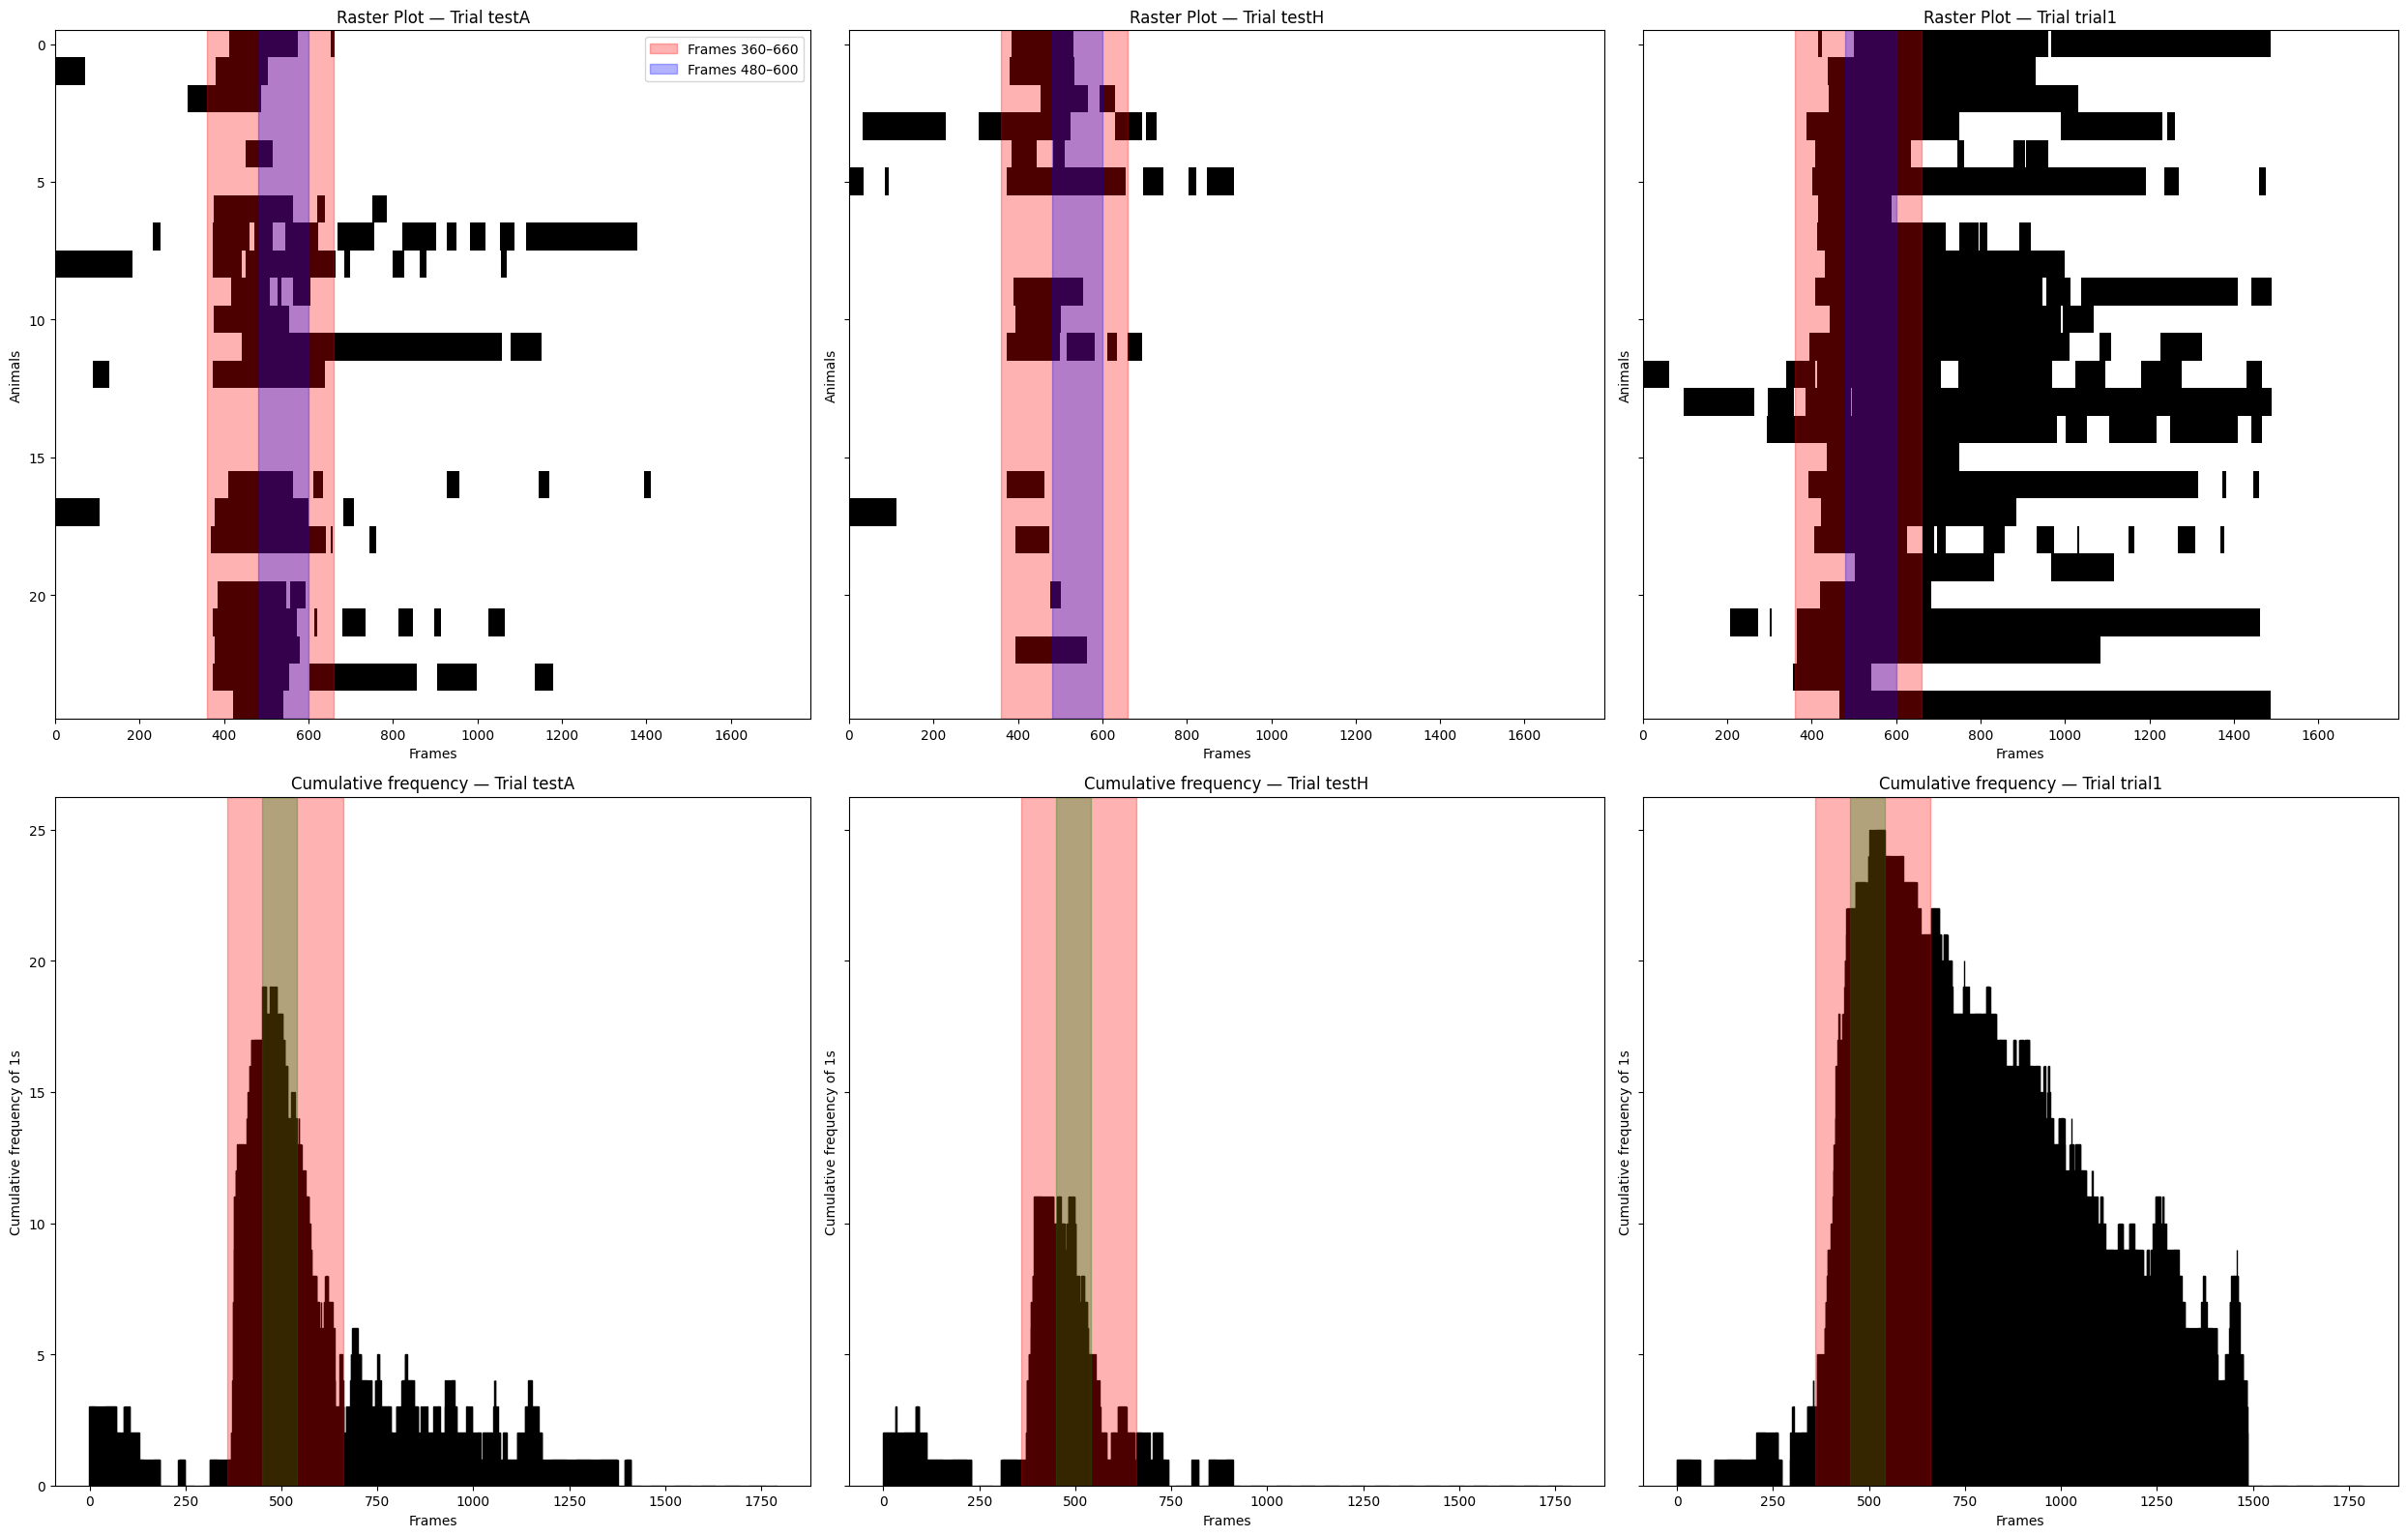

In [26]:
# Assuming you have df_filtered with the expected structure and you want a 15-point moving-average window
window = 15

# Initialize a dictionary to store the binary responses for each trial
trial_responses = {}

# Build a binary response based on a threshold of −25
for (animal, trial), group in df_filtered.groupby(['animal', 'trial']):
    # Compute the difference between prob3 and prob1 in the Y position
    difference = (
        group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob3', 'y')]
        - group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1', 'y')]
    )

    # Smooth the difference
    smoothed_difference = difference.rolling(window=window, min_periods=1).mean()

    # Take the top 100 values of the smoothed difference
    top_100_values = smoothed_difference.nlargest(100)

    # Median of the top 100 values (0.0 if empty)
    top_100_median = top_100_values.median() if not top_100_values.empty else 0.0

    # Normalize by subtracting the median of the top 100 values
    normalized_data = smoothed_difference - top_100_median

    # Clip to frame 1790
    normalized_data = normalized_data.loc[group['frames'] <= 1790]
    group = group.loc[group['frames'] <= 1790]

    # Binary response (1 if below −25)
    binary_response = (normalized_data < -25).astype(int)

    # Store responses in the dictionary
    trial_responses.setdefault(trial, {})[animal] = binary_response.values

# Create a figure with 2 rows (top: raster, bottom: cumulative histogram) and one column per trial
num_trials = len(trial_responses)
fig, axes = plt.subplots(2, num_trials, figsize=(25, 16), sharex='row', sharey='row')

# If there is only one trial, axes is 1D; normalize to 2D indexing
if num_trials == 1:
    axes = np.array(axes).reshape(2, 1)

for i, (trial, responses) in enumerate(trial_responses.items()):
    # Create an empty array for the raster plot
    num_animals = len(responses)
    raster_plot = np.zeros((num_animals, 1790), dtype=int)

    # Fill the array with each animal's binary responses
    for idx, (animal, response) in enumerate(responses.items()):
        raster_plot[idx, :len(response)] = response

    # Raster plot
    axes[0, i].imshow(raster_plot, cmap='binary', aspect='auto', interpolation='none')

    # Add translucent stimulus windows
    axes[0, i].axvspan(360, 660, color='red', alpha=0.3, label='Frames 360–660')
    axes[0, i].axvspan(480, 600, color='blue', alpha=0.3, label='Frames 480–600')

    axes[0, i].set_xlabel('Frames')
    axes[0, i].set_ylabel('Animals')
    axes[0, i].set_title(f'Raster Plot — Trial {trial}')
    if i == 0:
        axes[0, i].legend(loc='upper right')

    # Cumulative frequency histogram (sum across animals per frame)
    frame_counts = np.sum(raster_plot, axis=0)
    axes[1, i].bar(np.arange(len(frame_counts)), frame_counts, edgecolor='black')

    # Same translucent windows for reference
    axes[1, i].axvspan(360, 660, color='red', alpha=0.3)
    axes[1, i].axvspan(450, 540, color='green', alpha=0.3)

    axes[1, i].set_xlabel('Frames')
    axes[1, i].set_ylabel('Cumulative frequency of 1s')
    axes[1, i].set_title(f'Cumulative frequency — Trial {trial}')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


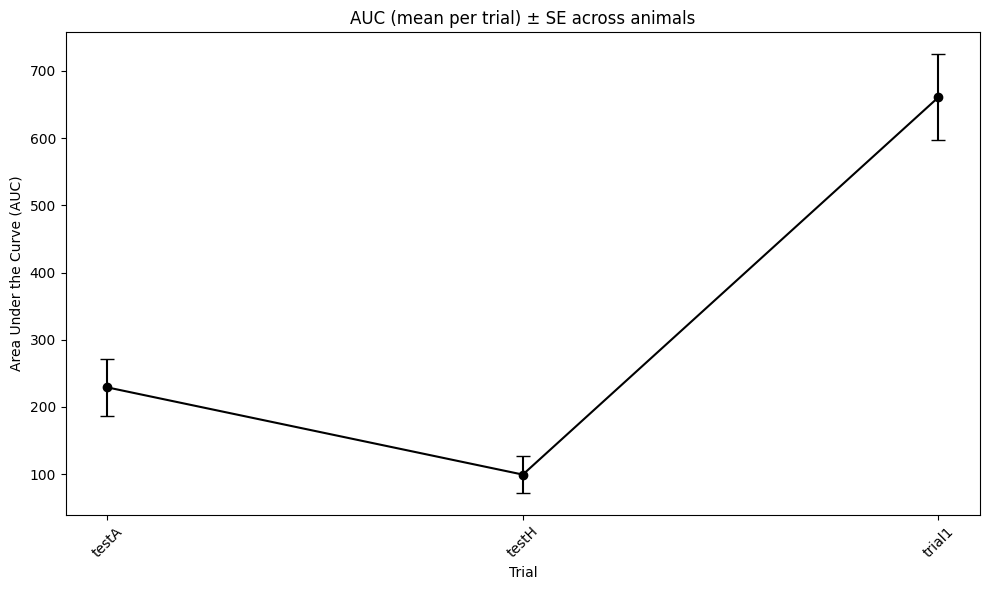

In [27]:
# Parameters
window = 15
num_frames = 1700
FRAME_MAX = 1790
UMBRAL_BIN = -25
MIN_BOUT = 15  # minimum duration of consecutive 1s to keep (in frames)

trial_responses = {}

for (animal, trial), group in df_filtered.groupby(['animal', 'trial']):
    # Difference prob3 - prob1 in Y
    diff = (group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob3', 'y')]
            - group[('DLC_resnet50_AbejasJun19shuffle1_150000', 'prob1', 'y')])

    # Smoothing
    sm = diff.rolling(window=window, min_periods=1).mean()

    # Normalization by the median of the top 100 values of the smoothed signal
    top_100 = sm.nlargest(100)
    top_100_median = top_100.median() if len(top_100) > 0 else 0.0
    norm = sm - top_100_median

    # Clip to FRAME_MAX and then to num_frames
    m = group['frames'] <= FRAME_MAX
    norm = norm.loc[m]
    frames_sub = group.loc[m, 'frames']
    m2 = frames_sub <= num_frames
    norm = norm.loc[m2]

    # Binarization
    binary = (norm < UMBRAL_BIN).astype(int).values

    # Filter out short sequences (≥ MIN_BOUT)
    def filter_short_sequences(x, threshold=MIN_BOUT):
        y = np.zeros_like(x)
        count = 0
        for i, v in enumerate(x):
            if v == 1:
                count += 1
            else:
                if count >= threshold:
                    y[i-count:i] = 1
                count = 0
        # Close the final run if the vector ends with 1s
        if count >= threshold:
            y[len(x)-count:] = 1
        return y

    binary = filter_short_sequences(binary, MIN_BOUT)

    # Save
    trial_responses.setdefault(trial, {})[animal] = binary

# ---- AUC per animal and correct SE across animals (trapezoids) ----
def auc_trapz(y):
    # dx = 1 frame
    return np.trapz(y, dx=1)

trials = []
auc_mean_list = []
auc_se_list = []

for trial, responses in trial_responses.items():
    # Ensure uniform length (num_frames)
    mats = []
    for animal, resp in responses.items():
        r = np.asarray(resp)
        if len(r) < num_frames:
            r = np.pad(r, (0, num_frames - len(r)))
        else:
            r = r[:num_frames]
        mats.append(r)
    M = np.vstack(mats)  # shape: n_animals x num_frames

    # AUC per animal
    auc_animals = np.apply_along_axis(auc_trapz, 1, M)
    auc_mean = auc_animals.mean()
    # Standard error across animals
    n = len(auc_animals)
    auc_se = auc_animals.std(ddof=1) / np.sqrt(n) if n > 1 else 0.0

    trials.append(trial)
    auc_mean_list.append(auc_mean)
    auc_se_list.append(auc_se)

# Sort by trial if not already ordered
order = np.argsort(trials)
trials = np.array(trials)[order]
auc_mean_list = np.array(auc_mean_list)[order]
auc_se_list = np.array(auc_se_list)[order]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(trials, auc_mean_list, yerr=auc_se_list, fmt='-o', color='black', capsize=5)
ax.set_xlabel('Trial')
ax.set_ylabel('Area Under the Curve (AUC)')
ax.set_title('AUC (mean per trial) ± SE across animals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Define your mask based on the conditions